In [2]:
import requests
import json
import pandas as pd
import calendar
import numpy as np
import io
import tarfile
import os

(2%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data
(3%) A discussion of the preliminary results:
This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis
You must discuss some of the potential ethical considerations (or explain why there aren't any) for your project

In [3]:
owner = "AtharvaN88"
repo = "GSE-by-year"
api_url = f"https://api.github.com/repos/{owner}/{repo}/contents"

response = requests.get(api_url)
if response.status_code != 200:
    raise Exception(f"Failed to fetch repo contents: {response.status_code}, {response.text}")

repo_contents = response.json()

tar_files = [item for item in repo_contents if item['name'].endswith('.tar.gz')]
all_dataframes = []

for tar_file in tar_files:
    tar_url = tar_file['download_url']
    tar_response = requests.get(tar_url)
    
    if tar_response.status_code != 200:
        raise Exception(f"Failed to download {tar_file['name']}: {tar_response.status_code}, {tar_response.text}")
    
    with tarfile.open(fileobj=io.BytesIO(tar_response.content), mode="r:gz") as tar:
        for member in tar.getmembers():
            if member.isfile() and member.name.endswith('.csv'):
                csv_file = tar.extractfile(member)
                if csv_file:
                    df = pd.read_csv(csv_file)
                    all_dataframes.append(df)

main_df = pd.concat(all_dataframes, ignore_index=True)

print(main_df)


        service_date time_period      stop_id        station_name  \
0         2021-12-31  (00:00:00)  place-alfcl             Alewife   
1         2021-12-31  (00:00:00)  place-chmnl         Charles/MGH   
2         2021-12-31  (00:00:00)  place-coecl              Copley   
3         2021-12-31  (00:00:00)  place-harsq             Harvard   
4         2021-12-31  (00:00:00)  place-sstat       South Station   
...              ...         ...          ...                 ...   
4169809   2018-01-01  (23:30:00)  place-welln          Wellington   
4169810   2018-01-01  (23:30:00)  place-wimnl         Wood Island   
4169811   2018-01-01  (23:30:00)  place-wondl          Wonderland   
4169812   2018-01-01  (23:30:00)  place-wtcst  World Trade Center   
4169813   2018-01-01  (23:30:00)          NaN         Charles/MGH   

        route_or_line  gated_entries  
0            Red Line            2.0  
1            Red Line            1.0  
2          Green Line           12.0  
3            Re

In [4]:
# take a specific year from the dataframe
main_df['year'] = [i[:4] for i in main_df['service_date']]
entry_df = main_df.loc[main_df['year'] == '2021']
# create a timestamp column made from the timpe_period column (converts to hours)
entry_df['timestamp'] = [int(i[1:3]) + int(i[4:5]) / 6 for i in entry_df['time_period']]

entry_df

C:\Users\gjr41\AppData\Local\Temp\ipykernel_21256\1683379597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entry_df['timestamp'] = [int(i[1:3]) + int(i[4:5]) / 6 for i in entry_df['time_period']]


,service_date,time_period,stop_id,station_name,route_or_line,gated_entries,year,timestamp
0,2021-12-31,(00:00:00),place-alfcl,Alewife,Red Line,2.0,2021,0.0
1,2021-12-31,(00:00:00),place-chmnl,Charles/MGH,Red Line,1.0,2021,0.0
2,2021-12-31,(00:00:00),place-coecl,Copley,Green Line,12.0,2021,0.0
3,2021-12-31,(00:00:00),place-harsq,Harvard,Red Line,1.0,2021,0.0
4,2021-12-31,(00:00:00),place-sstat,South Station,Red Line,0.7,2021,0.0
...,...,...,...,...,...,...,...,...
1031670,2021-01-01,(23:30:00),place-sull,Sullivan Square,Orange Line,5.0,2021,23.5
1031671,2021-01-01,(23:30:00),place-tumnl,Tufts Medical Center,Orange Line,4.0,2021,23.5
1031672,2021-01-01,(23:30:00),place-welln,Wellington,Orange Line,4.0,2021,23.5
1031673,2021-01-01,(23:30:00),place-wondl,Wonderland,Blue Line,3.0,2021,23.5


In [5]:
def choose_entry_params(station_name=False, line='all', start_time=0, end_time=23.5):
    '''
    parameters:
        station_name (str): name of an mbta station (default to False)
        line (str): mbta line to observe (defaults to all lines)
        start_time (int): first hour of data collection (defaults to 12am)
        end_time (int): last hour of data collection (defaults to 11:30pm)
    returns: x and y arrays of the subset entry data
    does: gets a subset of entry_df that meets the given parameters
    '''
    final_df = entry_df
    # subset by line
    if line.title() in ['Green', 'Red', 'Orange', 'Blue']:
        final_df = final_df.loc[(final_df['route_or_line'] == f'{line} Line')]

    # subset by station
    if station_name:
        final_df = final_df.loc[(final_df['station_name'] == station_name)]

    # subset by start time
    if start_time != 0:
        final_df = final_df.loc[(final_df['timestamp'] >= start_time)]

    # subset by end time
    if end_time != 23.5:
        final_df = final_df.loc[(final_df['timestamp'] <= end_time)]

    # convert dataframe to x and y arrays for linear algebra
    x = final_df['timestamp'].to_numpy()
    y = final_df['gated_entries'].to_numpy()

    return x, y

In [6]:
def line_of_best_fit(X, y):
    '''
    parameters: X (array): either a 1-d or 2-d array of predictor values (does not include bias column), y (array): a 1-d array of corresponding 
    response values for the X parameter
    returns: b (array): vector containing the coefficients for the line of best fit
    does: finds the coefficients for the line of best fit from the given predictor and response values
    '''

    # add a bias column to X:
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    # calculate b: the coefficients for the line of best fit
    b = np.matmul(np.linalg.inv(np.matmul(Xnew.T, Xnew)), np.matmul(Xnew.T, y))
    
    return b

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def get_mse(y_true, y_pred):
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_true - y_pred) ** 2)

def show_fit(X, y, slope, intercept, station_name):
    plt.figure()
    
    # in case this wasn't done before, transform the input data into numpy arrays and flatten them
    x = np.array(X).ravel()
    y = np.array(y).ravel()
    
    # plot the actual data
    plt.scatter(x, y, label='data')
    
    # compute linear predictions 
    # x is a numpy array so each element gets multiplied by slope and intercept is added
    y_pred = slope * x + intercept
    
    # plot the linear fit
    plt.plot(x, y_pred, color='black',
             ls=':',
             label='linear fit')
    
    plt.legend()
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Gated Entries')
    plt.suptitle(f'Gated Entries by the Hour (5am-5pm) for {station_name}')
    
    # print the mean squared error
    y_pred = slope * x + intercept
    mse = get_mse(y_true=y, y_pred=y_pred)
    plt.title(f'y_hat = {slope:.3f} * x + {intercept:.3f}, MSE = {mse:.3f}')

Scores for Government Center: r^2 = 0.2464 and MSE = 1460.433
Scores for Back Bay: r^2 = 0.4647 and MSE = 3495.972
Scores for Downtown Crossing: r^2 = 0.6929 and MSE = 1808.711


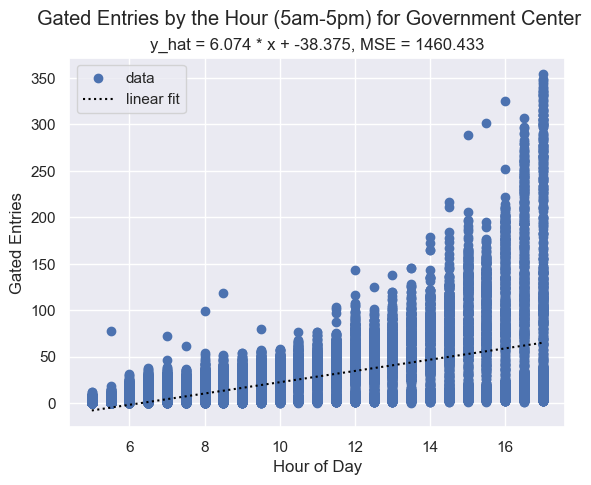

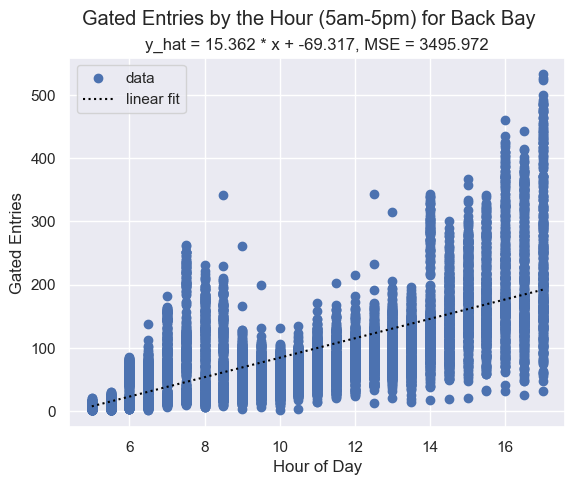

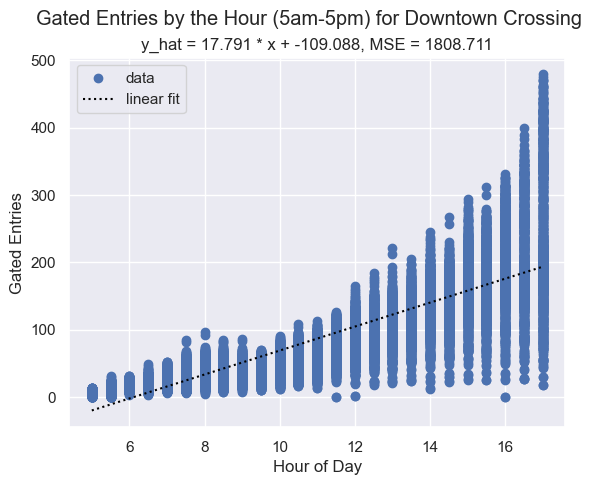

In [9]:
for station in ['Government Center', 'Back Bay', 'Downtown Crossing']:
    # get arrays for x, y to make line of best fit and plot
    x, y = choose_entry_params(station, start_time=5, end_time=17)
    b = line_of_best_fit(x, y)
    show_fit(x, y, b[1], b[0], station)

    # getting summary statistics:
    from sklearn.metrics import r2_score
    
    x_bias = np.column_stack([np.ones(x.shape[0]), x])
    # calculate predicted y values
    ypreds = np.matmul(x_bias, b)
    # calculate residuals
    resids = y - ypreds
    
    # mse
    mse = (resids**2).mean()
    
    # r^2
    r2 = r2_score(y, ypreds)
    print(f'Scores for {station}: r^2 = {round(r2, 4)} and MSE = {round(mse, 3)}')

In [9]:
# getting summary statistics:
from sklearn.metrics import r2_score

x_bias = np.column_stack([np.ones(x.shape[0]), x])
# calculate predicted y values
ypreds = np.matmul(x_bias, b)
# calculate residuals
resids = y - ypreds

# mse
mse = (resids**2).mean()

# r^2
r2 = r2_score(y, ypreds)
print(f'r^2 = {round(r2, 4)} and MSE = {round(mse, 3)}')

r^2 = 0.6929 and MSE = 1808.711


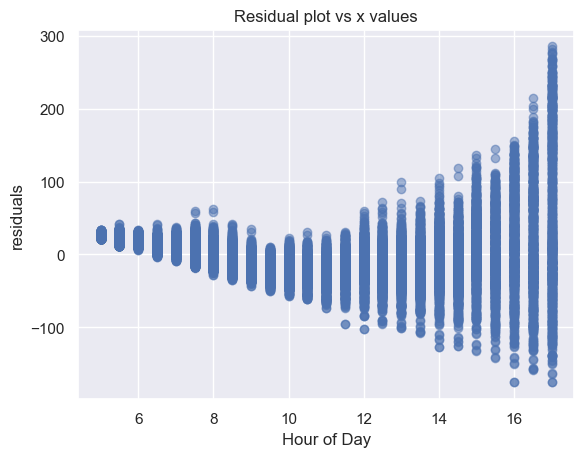

In [13]:
# plot residuals vs the x feature
plt.scatter(x, resids, alpha=.5)
plt.xlabel('Hour of Day')
plt.ylabel('residuals')
plt.title('Residual plot vs x values')
plt.show()
#bruh

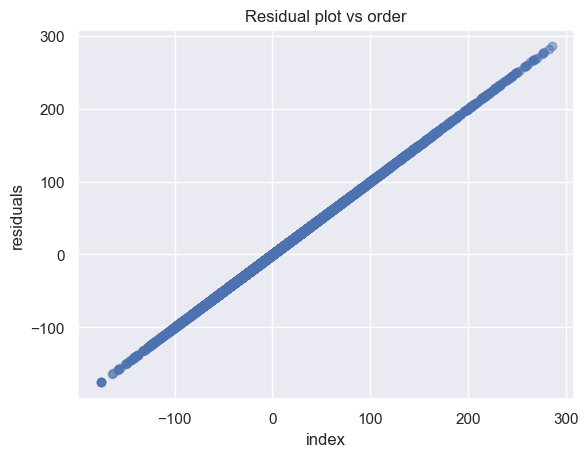

In [14]:
# plot residuals vs. the index/order :(
plt.scatter((resids), resids, alpha=.5)
plt.xlabel('index')
plt.ylabel('residuals')
plt.title('Residual plot vs order')
plt.show()

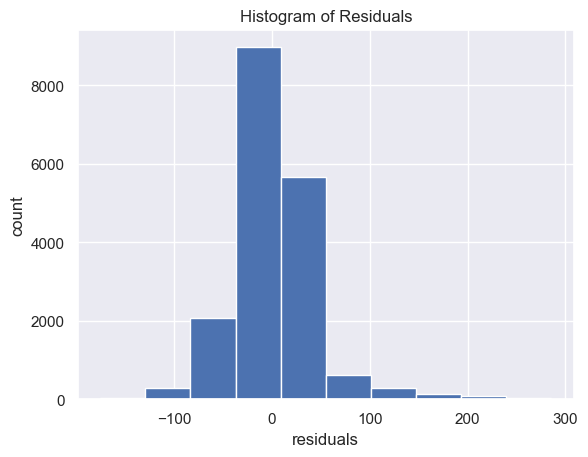

In [12]:
# plot histogram of residual values
plt.hist(resids)
plt.xlabel('residuals')
plt.ylabel('count')
plt.title('Histogram of Residuals')
plt.show()